In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project

from samples.face.face import FaceConfig, FaceDataset
ROOT_DIR = os.path.abspath("../..")

/home/jho/anaconda3/envs/maskrcnn-tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jho/anaconda3/envs/maskrcnn-tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jho/anaconda3/envs/maskrcnn-tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jho/anacon

In [2]:
# Import Mask RCNN
sys.path.append(ROOT_DIR)
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline

In [3]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """
    Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default isze attribute to control the size
    of rendered images
    """
    
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax


## Configurations

Configurations are defined in face.py

In [5]:
config = FaceConfig()
FACE_DIR = os.path.join(ROOT_DIR, "samples/face/face_data")

## Dataset

In [6]:
# Load dataset
# Get the dataset 'CelebA'

dataset = FaceDataset()
dataset.load_face(FACE_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Loading images: 100%|██████████| 3200/3200 [00:04<00:00, 672.29it/s]


Image Count: 3200
Class Count: 2
  0. BG                                                
  1. face                                              


### Training dataset

In [7]:
# Training dataset
dataset_train = FaceDataset()
dataset_train.load_face(FACE_DIR, 'train')
dataset_train.prepare()

Loading images: 100%|██████████| 3200/3200 [00:03<00:00, 928.63it/s]


### Validation Dataset

In [8]:
# Validation dataset
dataset_val = FaceDataset()
dataset_val.load_face(FACE_DIR, 'val')
dataset_val.prepare()


Loading images: 100%|██████████| 355/355 [00:00<00:00, 678.94it/s]


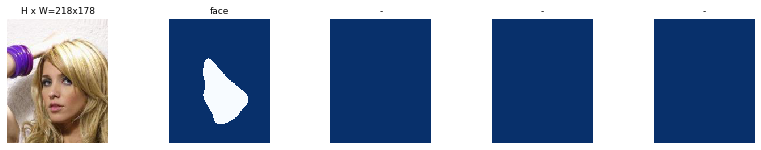

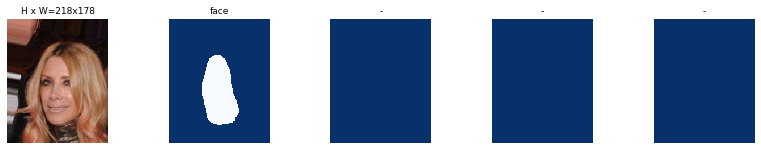

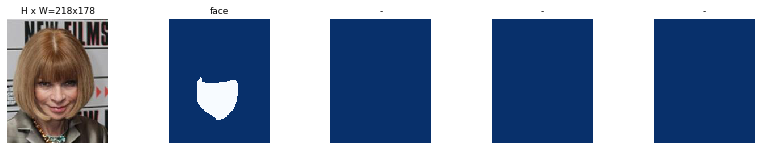

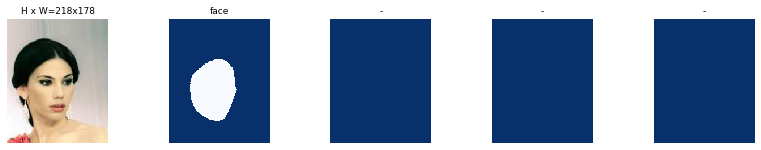

In [9]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


## Create Model

In [10]:
# Create model in training mode
model = modellib.MaskRCNN(
        mode="training", 
        config=config,
        model_dir=MODEL_DIR)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
box_ind is deprecated, use box_indices instead


In [11]:
# Which weights to start with?
init_weight = "coco" # imagenet, coco, or last

if init_weight == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_weight == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                        exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                 "mrcnn_bbox", "mrcnn_mask"])
    
elif init_weight == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)



## Training

Train in two stages:

 1. Only the heads. Here we're freezing all the backbone layers and trainging only the randomly intialized layers
 (.e. the ones that we didn't use pre-trained weights from MS COCO).
 To train only the head layers, pass layers='heads' to the train() function.
 2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process.
 Simply pass layers="all to train all layers.
 

In [12]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=1,
            layers='heads')




Starting at epoch 0. LR=0.001

Checkpoint Path: /home/jho/projects/Mask_RCNN/logs/face20200407T0000/mask_rcnn_face_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_m

/home/jho/anaconda3/envs/maskrcnn-tensorflow/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/jho/anaconda3/envs/maskrcnn-tensorflow/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/jho/anaconda3/envs/maskrcnn-tensorflow/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/jho/anaconda3/envs/maskrcnn-tensorflow/lib/python3.7

UnknownError: 2 root error(s) found.
  (0) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv1/convolution}}]]
	 [[proposal_targets/strided_slice_17/_4363]]
  (1) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv1/convolution}}]]
0 successful operations.
0 derived errors ignored.